In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import time 


In [2]:
dataset_dir = 'CNRPark-Patches-150x150/'
dataset_dir_EXT = 'CNR-EXT-150x150/'
split_train_file = 'splits/CNRParkAB/train.txt' 
split_val_file = 'splits/CNRParkAB/val.txt' 
split_test_EXT = 'CNR-EXT-150x150/LABELS/test.txt'
split_train_EXT = 'CNR-EXT-150x150/LABELS/train.txt'
split_val_EXT = 'CNR-EXT-150x150/LABELS/val.txt'

# Define the image size and batch size
image_size = (32, 32)  
batch_size = 64

# Create a function to load and preprocess images
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label


def create_dataset(split_file, dataset_dir):    
    image_paths = []
    labels = []

    with open(split_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.split()
            if len(parts) == 2:
                image_path = os.path.join(dataset_dir, parts[0])
                label = int(parts[1])
                image_paths.append(image_path)
                labels.append(label)

    labels = np.array(labels, dtype=np.int32)
    labels = tf.one_hot(labels, 2)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_preprocess_image)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

train_dataset = create_dataset(split_train_EXT, dataset_dir_EXT)
val_dataset = create_dataset(split_val_EXT, dataset_dir_EXT)
test_dataset = create_dataset(split_test_EXT, dataset_dir_EXT)


(64, 32, 32, 3)


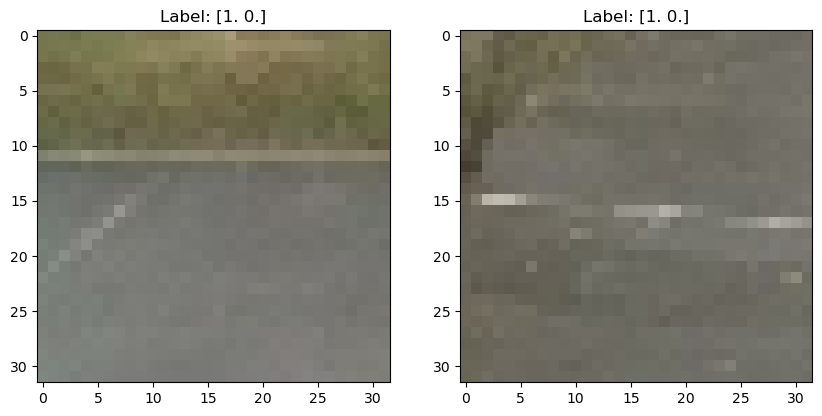

(64, 32, 32, 3)


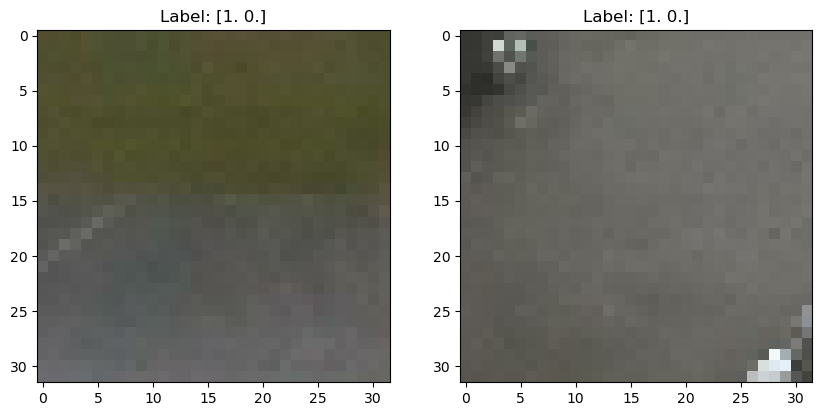

In [3]:
# showing images from train_dataset
for images, labels in train_dataset.take(2): 
    print(images.shape)
    plt.figure(figsize=(10, 5))
    for i in range(2):  
        plt.subplot(1, 2, i + 1)
        im = images[i] / 255.0 
        plt.imshow(im)
        plt.title("Label: {}".format(labels[i].numpy()))
    plt.show()

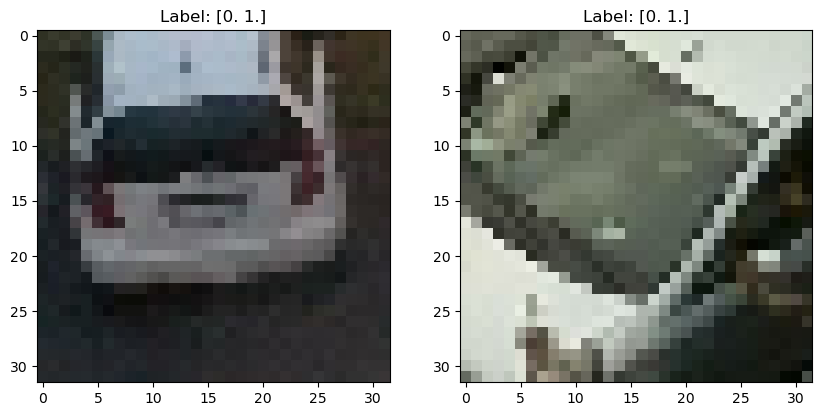

In [4]:
# showing images from val_dataset
for images, labels in val_dataset.take(1): 
    plt.figure(figsize=(10, 5))
    for i in range(2):  
        plt.subplot(1, 2, i + 1)
        im = images[i] / 255.0 
        plt.imshow(im)
        plt.title("Label: {}".format(labels[i].numpy()))
    plt.show()

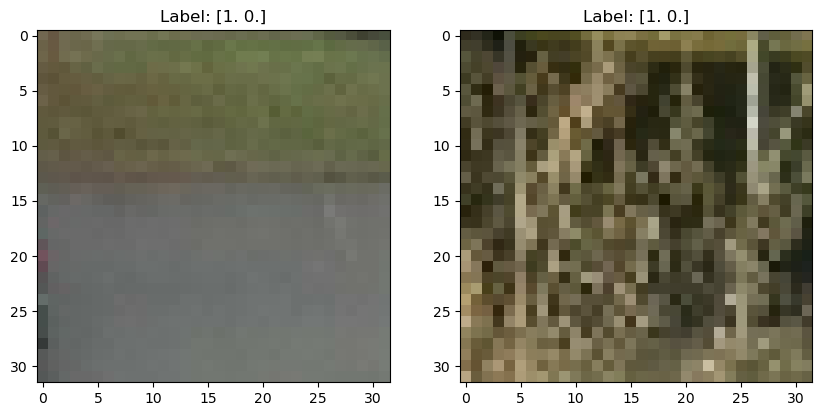

In [5]:
# showing images from test_dataset
for images, labels in test_dataset.take(1): 
    plt.figure(figsize=(10, 5))
    for i in range(2):  
        plt.subplot(1, 2, i + 1)
        im = images[i] / 255.0 
        plt.imshow(im)
        plt.title("Label: {}".format(labels[i].numpy()))
    plt.show()

In [6]:
train_size = tf.data.experimental.cardinality(train_dataset).numpy()
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
test_size = tf.data.experimental.cardinality(test_dataset).numpy()

print(f"Train dataset size: {train_size} batches")
print(f"Val dataset size: {val_size} batches")
print(f"Test dataset size: {test_size} batches")

Train dataset size: 1477 batches
Val dataset size: 292 batches
Test dataset size: 498 batches


## **Mini AlexNet**

In [18]:
num_classes = 2  
input_shape = (32, 32, 3)  

# mAlexNet
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, kernel_size=4, strides=1, activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(20, kernel_size=3, strides=1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Conv2D(30, kernel_size=2, strides=1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(48, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    metrics=['accuracy']
)

Conv1 Output Shape: (None, 29, 29, 16)
MaxPool1 Output Shape: (None, 14, 14, 16)
Conv2 Output Shape: (None, 12, 12, 20)
MaxPool2 Output Shape: (None, 6, 6, 20)
Conv3 Output Shape: (None, 5, 5, 30)
MaxPool3 Output Shape: (None, 2, 2, 30)
Flatten Output Shape: (None, 120)
Dense Output Shape: (None, 48)
Final Output Shape: (None, 2)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 29, 29, 16)        784       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 12, 12, 20)        2900      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 6, 6, 20)      

### Regular Training

In [19]:
epochs = 50

training_start_malexnet = time.time()
# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)
training_end_malexnet = time.time()

# Save the trained model
model.save('models/malexnet_standard.h5')

Epoch 1/50
1477/1477 [==============================] - 16s 10ms/step - loss: 0.1654 - accuracy: 0.9461 - val_loss: 0.1449 - val_accuracy: 0.9531
Epoch 2/50
1477/1477 [==============================] - 14s 10ms/step - loss: 0.0963 - accuracy: 0.9672 - val_loss: 0.1017 - val_accuracy: 0.9687
Epoch 3/50
1477/1477 [==============================] - 22s 15ms/step - loss: 0.0804 - accuracy: 0.9721 - val_loss: 0.1881 - val_accuracy: 0.9453
Epoch 4/50
1477/1477 [==============================] - 17s 11ms/step - loss: 0.0732 - accuracy: 0.9747 - val_loss: 0.0844 - val_accuracy: 0.9743
Epoch 5/50
1477/1477 [==============================] - 16s 11ms/step - loss: 0.0643 - accuracy: 0.9779 - val_loss: 0.0780 - val_accuracy: 0.9767
Epoch 6/50
1477/1477 [==============================] - 16s 11ms/step - loss: 0.0602 - accuracy: 0.9791 - val_loss: 0.0880 - val_accuracy: 0.9751
Epoch 7/50
1477/1477 [==============================] - 15s 10ms/step - loss: 0.0537 - accuracy: 0.9822 - val_loss: 0.1065 -

/Users/aruzhan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


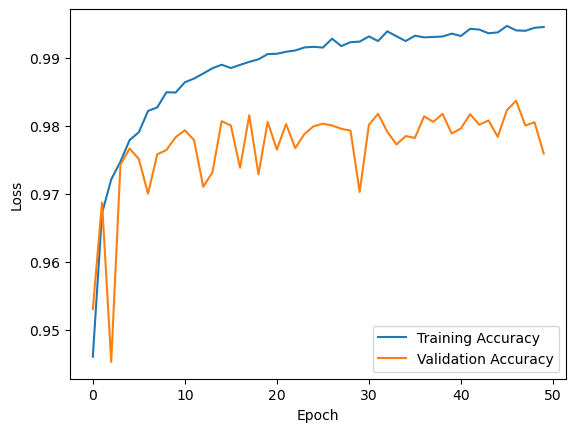

In [20]:
# Plot training and validation loss over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
inference_start_malexnet = time.time()
results = model.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
inference_end_malexnet = time.time()
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")

498/498 [==============================] - 3s 5ms/step - loss: 0.1118 - accuracy: 0.9771
Testing on CNR_EXT dataset: test loss: 0.11178336292505264, test acc: 0.9770934581756592


### Quantization

In [22]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    # Model has only one input so each data point has one element.
    #input_value = input_value.numpy()  # Convert TensorFlow tensor to NumPy array
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/malexnet_lite2.tflite', 'wb') as f:
    f.write(quantized_model)


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmp9vhf_tkr/assets


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmp9vhf_tkr/assets
/Users/aruzhan/anaconda3/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-11-20 21:41:36.674826: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-20 21:41:36.674979: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-20 21:41:36.677286: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmp9vhf_tkr
2023-11-20 21:41:36.678129: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-20 21:41:36.678133: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn

In [23]:
interpreter = tf.lite.Interpreter(model_path='models/malexnet_lite2.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
print("input_index:", input_index)

input_shape = interpreter.get_input_details()[0]['shape']
print("Expected input shape:", input_shape)

# Initialize variables for accuracy calculation
correct_predictions = 0
total_samples = 0

for batch_input_data, batch_true_labels in val_dataset:
    # Iterate through each sample in the batch
    for i in range(batch_input_data.shape[0]):        
        input_data = batch_input_data[i:i + 1]

        # Set input tensor
        interpreter.set_tensor(input_index, input_data.numpy())

        # Run inference
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_index)  
        true_label = batch_true_labels[i].numpy()
        print(output_data)
        print(true_label)
        # predicted_label = (output_data >= 0.5).astype(int)
        # print(predicted_label)        
        # print(true_label)
        # if predicted_label == true_label:            
        #     correct_predictions += 1
        predicted_label = np.argmax(output_data, axis=1)
        print(predicted_label)
        true_label = np.argmax(true_label)
        print(true_label)
        if predicted_label == true_label:    
            print("here")
            correct_predictions += 1
        total_samples += 1

    if total_samples > 300:
        break
# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f'Accuracy: {accuracy * 100:.2f}%')
print(total_samples)


input_index: 0
Expected input shape: [ 1 32 32  3]
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.00390625]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.00390625]]
[1. 0.]
[0]
0
here
[[0.99609375 0.00390625]]
[1. 0.]
[0]
0
here
[[0.96875 0.03125]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.      

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Data augmentation

In [24]:
# Training model with data augmentation
def load_and_augment_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.random_flip_left_right(image)  # to simulate varying car orientations facing the camera 
    # image = tf.image.random_flip_up_down(image)  # to simulate varying car orientations facing the camera
    image = tf.image.random_brightness(image, max_delta=0.4) # to simulate parking lot in different daytimes and lighting conditions
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2) # to simulate parking lot in different daytimes and lighting conditions
    # image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) # to simulate varying angle of the camera
    
    image = tf.image.resize(image, image_size)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    return image, label

def create_dataset(split_file, dataset_dir):    
    image_paths = []
    labels = []

    with open(split_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.split()
            if len(parts) == 2:
                image_path = os.path.join(dataset_dir, parts[0])
                label = int(parts[1])
                image_paths.append(image_path)
                labels.append(label)

    labels = np.array(labels, dtype=np.int32)
    labels = tf.one_hot(labels, 2)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_augment_image)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

train_dataset_augmented = create_dataset(split_train_EXT, dataset_dir_EXT)

(64, 32, 32, 3)


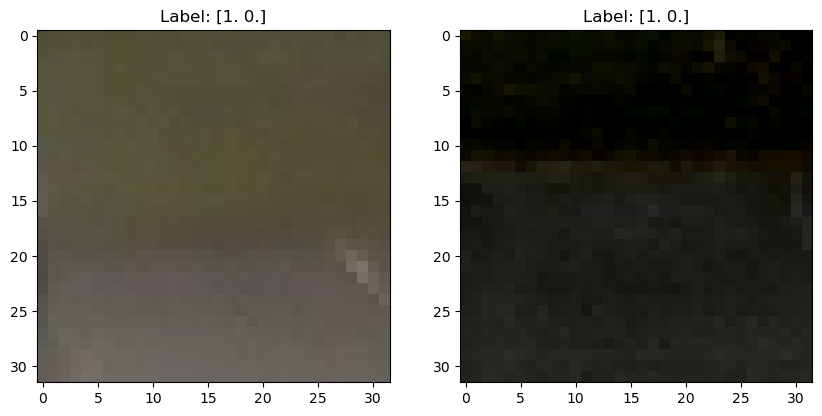

(64, 32, 32, 3)


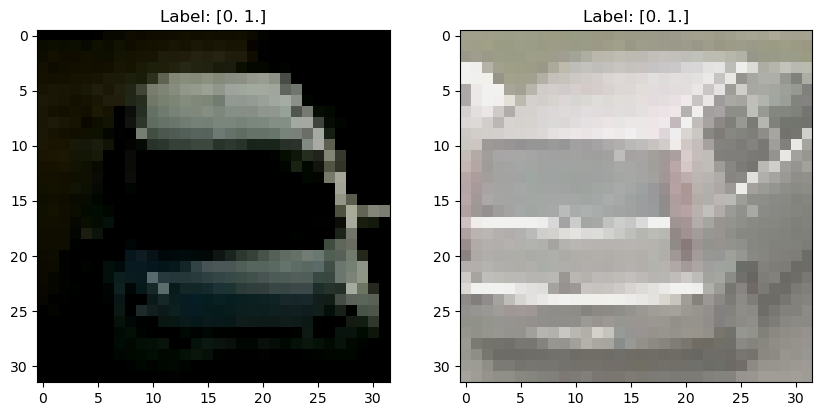

In [28]:
# showing images from train_dataset
for images, labels in train_dataset_augmented.take(2): 
    print(images.shape)
    plt.figure(figsize=(10, 5))
    for i in range(2):  
        plt.subplot(1, 2, i + 1)
        im = images[i] / 255.0 
        plt.imshow(im)
        plt.title("Label: {}".format(labels[i].numpy()))
    plt.show()

In [29]:
epochs = 50

training_start_malexnet_aug = time.time()
# Train the model
history_malexnet_aug = model.fit(
    train_dataset_augmented,
    epochs=epochs,
    validation_data=val_dataset
)
training_end_malexnet_aug = time.time()

# Save the trained model
model.save('models/malexnet_augmented.h5')

Epoch 1/50
1477/1477 [==============================] - 57s 38ms/step - loss: 0.1172 - accuracy: 0.9613 - val_loss: 0.0960 - val_accuracy: 0.9723
Epoch 2/50
1477/1477 [==============================] - 65s 43ms/step - loss: 0.0975 - accuracy: 0.9668 - val_loss: 0.0898 - val_accuracy: 0.9777
Epoch 3/50
1477/1477 [==============================] - 65s 44ms/step - loss: 0.0929 - accuracy: 0.9673 - val_loss: 0.1372 - val_accuracy: 0.9569
Epoch 4/50
1477/1477 [==============================] - 68s 46ms/step - loss: 0.0872 - accuracy: 0.9700 - val_loss: 0.0937 - val_accuracy: 0.9742
Epoch 5/50
1477/1477 [==============================] - 65s 43ms/step - loss: 0.0833 - accuracy: 0.9714 - val_loss: 0.0818 - val_accuracy: 0.9769
Epoch 6/50
1477/1477 [==============================] - 62s 41ms/step - loss: 0.0813 - accuracy: 0.9718 - val_loss: 0.0937 - val_accuracy: 0.9712
Epoch 7/50
1477/1477 [==============================] - 61s 41ms/step - loss: 0.0773 - accuracy: 0.9734 - val_loss: 0.0745 -

/Users/aruzhan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


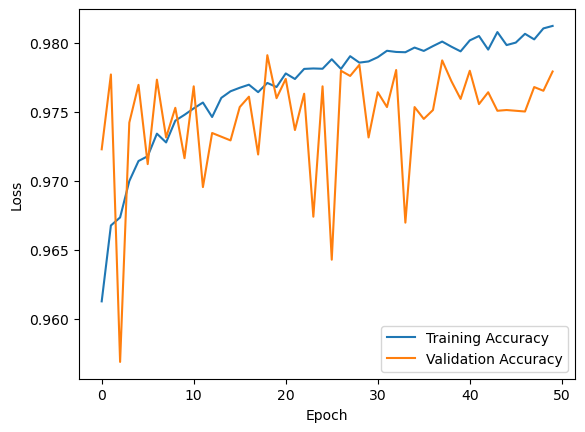

In [30]:
# Plot training and validation loss over epochs
plt.plot(history_malexnet_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_malexnet_aug.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
inference_start_malexnet_aug = time.time()
results = model.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
inference_end_malexnet_aug = time.time()
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")

498/498 [==============================] - 3s 5ms/step - loss: 0.0636 - accuracy: 0.9805
Testing on CNR_EXT dataset: test loss: 0.06356941163539886, test acc: 0.9805184602737427


### Data augmentation + Quantization

In [32]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    # Model has only one input so each data point has one element.
    #input_value = input_value.numpy()  # Convert TensorFlow tensor to NumPy array
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/malexnet_augmented_lite2.tflite', 'wb') as f:
    f.write(quantized_model)


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmpgptydzsf/assets


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmpgptydzsf/assets
/Users/aruzhan/anaconda3/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-11-20 22:40:18.361408: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-20 22:40:18.361538: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-20 22:40:18.362972: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmpgptydzsf
2023-11-20 22:40:18.363828: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-20 22:40:18.363832: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn

In [39]:
interpreter = tf.lite.Interpreter(model_path='models/malexnet_augmented_lite2.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
print("input_index:", input_index)

input_shape = interpreter.get_input_details()[0]['shape']
print("Expected input shape:", input_shape)

# Initialize variables for accuracy calculation
correct_predictions = 0
total_samples = 0

for batch_input_data, batch_true_labels in val_dataset:
    # Iterate through each sample in the batch
    for i in range(batch_input_data.shape[0]):        
        input_data = batch_input_data[i:i + 1]

        # Set input tensor
        interpreter.set_tensor(input_index, input_data.numpy())

        # Run inference
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_index)  
        true_label = batch_true_labels[i].numpy()
        print(output_data)
        print(true_label)
        # predicted_label = (output_data >= 0.5).astype(int)
        # print(predicted_label)        
        # print(true_label)
        # if predicted_label == true_label:            
        #     correct_predictions += 1
        predicted_label = np.argmax(output_data, axis=1)
        print(predicted_label)
        true_label = np.argmax(true_label)
        print(true_label)
        if predicted_label == true_label:    
            print("here")
            correct_predictions += 1
        total_samples += 1

    if total_samples > 300:
        break
# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f'Accuracy: {accuracy * 100:.2f}%')
print(total_samples)


input_index: 0
Expected input shape: [ 1 32 32  3]
[[0.99609375 0.00390625]]
[1. 0.]
[0]
0
here
[[0.94921875 0.05078125]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.85546875 0.14453125]]
[1. 0.]
[0]
0
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.9921875 0.0078125]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.00390625 0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.  

In [40]:
print('training time, malexnet standard: ', training_end_malexnet - training_start_malexnet)
print('inference time, malexnet standard: ', inference_end_malexnet - inference_start_malexnet)
print('training time, malexnet augmented: ', training_end_malexnet_aug - training_start_malexnet_aug)
print('inference time, malexnet augmented: ', inference_end_malexnet_aug - inference_start_malexnet_aug)

training time, malexnet standard:  747.1077117919922
inference time, malexnet standard:  2.5783531665802
training time, malexnet augmented:  3274.413395166397
inference time, malexnet augmented:  2.7615737915039062


## **Mini DenseNet**


In [96]:
def makemDenseNet(inputShape, modelName:str ='') -> keras.Model:
    def makeDenseBlock(groupCount: int, inputs):
        blockConcats = []
        x = tf.keras.layers.BatchNormalization()(inputs)
        x = tf.keras.layers.Conv2D(filters=16, kernel_size=(1, 1), activation="relu", padding="same")(x)
        x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same")(x)
        blockConcats.append(x)
        for count in range(groupCount):
            x = tf.keras.layers.Concatenate()(blockConcats) if len(blockConcats) > 1 else x
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Conv2D(filters=16, kernel_size=(1, 1), activation="relu", padding="same")(x)
            x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same")(x)
            blockConcats.append(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters=16, kernel_size=(1, 1), activation="relu", padding="same")(x)
        x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
        return x
    
    inputs = keras.Input(shape=inputShape, name="Input")
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(7, 7), strides=(5, 5), activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    
    x = makeDenseBlock(groupCount=2, inputs=x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(units=2, activation="sigmoid")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name=modelName)

In [97]:
# Mini DenseNet
mDenseNet = makemDenseNet(inputShape=(32, 32, 3), modelName='mDenseNet')

opt = tf.optimizers.Adam()
mDenseNet.compile(
    optimizer = opt,
    loss = keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = ["accuracy"]
)

mDenseNet.summary()

Model: "mDenseNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_66 (Conv2D)          (None, 6, 6, 16)             2368      ['Input[0][0]']               
                                                                                                  
 max_pooling2d_24 (MaxPooli  (None, 2, 2, 16)             0         ['conv2d_66[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 batch_normalization_24 (Ba  (None, 2, 2, 16)             64        ['max_pooling2d_24[0][

### Regular Training

In [101]:
training_start_mdensenet = time.time()
history_mdensenet = mDenseNet.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)
training_end_mdensenet = time.time()

Epoch 1/50


1477/1477 [==============================] - 9s 6ms/step - loss: 0.0220 - accuracy: 0.9928 - val_loss: 0.1321 - val_accuracy: 0.9691
Epoch 2/50
1477/1477 [==============================] - 8s 6ms/step - loss: 0.0211 - accuracy: 0.9923 - val_loss: 0.1864 - val_accuracy: 0.9602
Epoch 3/50
1477/1477 [==============================] - 9s 6ms/step - loss: 0.0216 - accuracy: 0.9928 - val_loss: 0.1408 - val_accuracy: 0.9683
Epoch 4/50
1477/1477 [==============================] - 9s 6ms/step - loss: 0.0205 - accuracy: 0.9928 - val_loss: 0.1646 - val_accuracy: 0.9651
Epoch 5/50
1477/1477 [==============================] - 11s 7ms/step - loss: 0.0201 - accuracy: 0.9930 - val_loss: 0.2569 - val_accuracy: 0.9500
Epoch 6/50
1477/1477 [==============================] - 8s 6ms/step - loss: 0.0201 - accuracy: 0.9930 - val_loss: 0.1962 - val_accuracy: 0.9584
Epoch 7/50
1477/1477 [==============================] - 9s 6ms/step - loss: 0.0193 - accuracy: 0.9931 - val_loss: 0.1664 - val_accuracy: 0.9642
Ep

In [129]:
# Save the trained model
mDenseNet.save('models/mdensenet_standard.h5')

/Users/aruzhan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


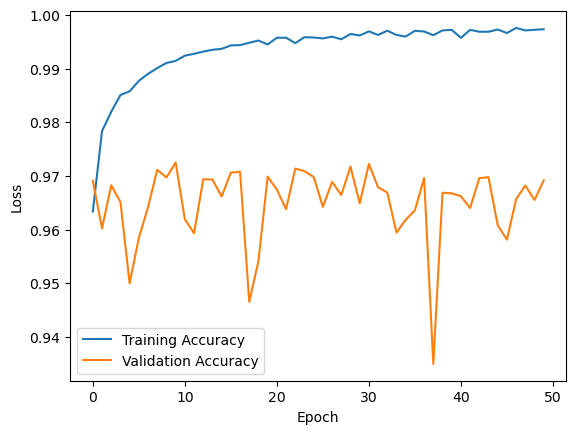

In [263]:
# Plot training and validation loss over epochs
plt.plot(history_mdensenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_mdensenet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [105]:
inference_start_mdensenet = time.time()
results = mDenseNet.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
inference_end_mdensenet = time.time()
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")

498/498 [==============================] - 2s 4ms/step - loss: 0.1172 - accuracy: 0.9749
Testing on CNR_EXT dataset: test loss: 0.11718332022428513, test acc: 0.9748939275741577


### Quantization

In [108]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    # Model has only one input so each data point has one element.
    #input_value = input_value.numpy()  # Convert TensorFlow tensor to NumPy array
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(mDenseNet)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/mdensenet_lite2.tflite', 'wb') as f:
    f.write(quantized_model)


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmp45hatnp8/assets


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmp45hatnp8/assets
/Users/aruzhan/anaconda3/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-11-15 20:33:15.859789: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-15 20:33:15.859827: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-15 20:33:15.860407: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmp45hatnp8
2023-11-15 20:33:15.862742: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-15 20:33:15.862749: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn

In [136]:
interpreter = tf.lite.Interpreter(model_path='models/mdensenet_lite2.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
print("input_index:", input_index)

input_shape = interpreter.get_input_details()[0]['shape']
print("Expected input shape:", input_shape)

# Initialize variables for accuracy calculation
correct_predictions = 0
total_samples = 0

for batch_input_data, batch_true_labels in val_dataset:
    # Iterate through each sample in the batch
    for i in range(batch_input_data.shape[0]):        
        input_data = batch_input_data[i:i + 1]

        # Set input tensor
        interpreter.set_tensor(input_index, input_data.numpy())

        # Run inference
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_index)  
        true_label = batch_true_labels[i].numpy()
        print(output_data)
        print(true_label)
        # predicted_label = (output_data >= 0.5).astype(int)
        # print(predicted_label)        
        # print(true_label)
        # if predicted_label == true_label:            
        #     correct_predictions += 1
        predicted_label = np.argmax(output_data, axis=1)
        print(predicted_label)
        true_label = np.argmax(true_label)
        print(true_label)
        if predicted_label == true_label:    
            print("here")
            correct_predictions += 1
        total_samples += 1

    if total_samples > 300:
        break
# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f'Accuracy: {accuracy * 100:.2f}%')
print(total_samples)


input_index: 0
Expected input shape: [ 1 32 32  3]
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[1. 0.]
[1]
0
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[1. 0.]
[1]
0
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[1. 0.]
[1]
0
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[1. 0.]
[1]
0
[[0.         0.99609375]

### Data augmentation

In [206]:
training_start_mdensenet_aug = time.time()
# Train the model
history_mdensenet_aug = mDenseNet.fit(
    train_dataset_augmented,
    epochs=epochs,
    validation_data=val_dataset
)
training_end_mdensenet_aug = time.time()

# Save the trained model
model.save('models/mdensenet_augmented.h5')

Epoch 1/50
1477/1477 [==============================] - 54s 36ms/step - loss: 0.1315 - accuracy: 0.9525 - val_loss: 0.0922 - val_accuracy: 0.9716
Epoch 2/50
1477/1477 [==============================] - 52s 35ms/step - loss: 0.1101 - accuracy: 0.9593 - val_loss: 0.0841 - val_accuracy: 0.9727
Epoch 3/50
1477/1477 [==============================] - 52s 35ms/step - loss: 0.1045 - accuracy: 0.9618 - val_loss: 0.0966 - val_accuracy: 0.9664
Epoch 4/50
1477/1477 [==============================] - 52s 35ms/step - loss: 0.0983 - accuracy: 0.9640 - val_loss: 0.1063 - val_accuracy: 0.9633
Epoch 5/50
1477/1477 [==============================] - 59s 39ms/step - loss: 0.0974 - accuracy: 0.9637 - val_loss: 0.0953 - val_accuracy: 0.9685
Epoch 6/50
1477/1477 [==============================] - 53s 36ms/step - loss: 0.0935 - accuracy: 0.9652 - val_loss: 0.1241 - val_accuracy: 0.9582
Epoch 7/50
1477/1477 [==============================] - 52s 35ms/step - loss: 0.0902 - accuracy: 0.9671 - val_loss: 0.0830 -

/Users/aruzhan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


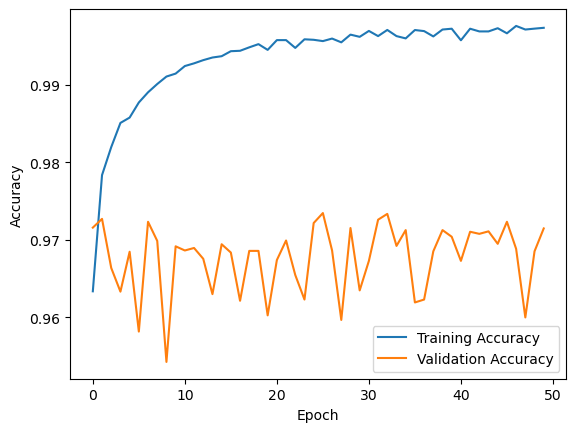

In [267]:
# Plot training and validation loss over epochs
plt.plot(history_mdensenet_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_mdensenet_aug.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

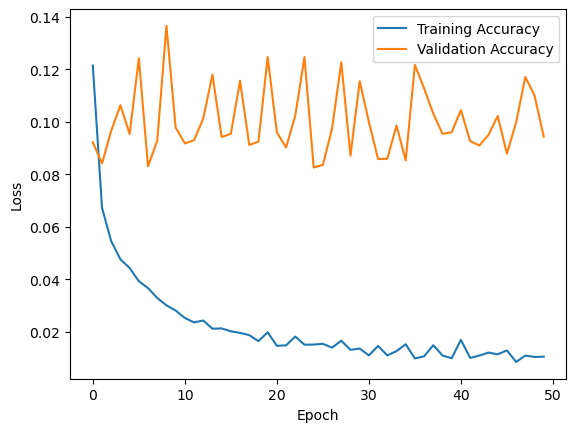

In [261]:
# Plot training and validation loss over epochs
plt.plot(history_mdensenet_aug.history['loss'], label='Training Accuracy')
plt.plot(history_mdensenet_aug.history['val_loss'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [208]:
inference_start_mdensenet_aug = time.time()
results = mDenseNet.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
inference_end_mdensenet_aug = time.time()
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")

498/498 [==============================] - 2s 4ms/step - loss: 0.0665 - accuracy: 0.9773
Testing on CNR_EXT dataset: test loss: 0.06651177257299423, test acc: 0.9772819876670837


### Data augmentation + Quantization

In [229]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    # Model has only one input so each data point has one element.
    #input_value = input_value.numpy()  # Convert TensorFlow tensor to NumPy array
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(mDenseNet)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/mdensenet_augmented_lite2.tflite', 'wb') as f:
    f.write(quantized_model)


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmphw7uefx5/assets


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmphw7uefx5/assets
/Users/aruzhan/anaconda3/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-11-16 00:43:16.923917: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-16 00:43:16.924143: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-16 00:43:16.925892: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmphw7uefx5
2023-11-16 00:43:16.927830: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-16 00:43:16.927836: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn

In [266]:
interpreter = tf.lite.Interpreter(model_path='models/mdensenet_augmented_lite2.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
print("input_index:", input_index)

input_shape = interpreter.get_input_details()[0]['shape']
print("Expected input shape:", input_shape)

# Initialize variables for accuracy calculation
correct_predictions = 0
total_samples = 0

for batch_input_data, batch_true_labels in val_dataset:
    # Iterate through each sample in the batch
    for i in range(batch_input_data.shape[0]):        
        input_data = batch_input_data[i:i + 1]

        # Set input tensor
        interpreter.set_tensor(input_index, input_data.numpy())

        # Run inference
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_index)  
        true_label = batch_true_labels[i].numpy()
        print(output_data)
        print(true_label)
        # predicted_label = (output_data >= 0.5).astype(int)
        # print(predicted_label)        
        # print(true_label)
        # if predicted_label == true_label:            
        #     correct_predictions += 1
        predicted_label = np.argmax(output_data, axis=1)
        print(predicted_label)
        true_label = np.argmax(true_label)
        print(true_label)
        if predicted_label == true_label:    
            print("here")
            correct_predictions += 1
        total_samples += 1

    if total_samples > 300:
        break
# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f'Accuracy: {accuracy * 100:.2f}%')
print(total_samples)


input_index: 0
Expected input shape: [ 1 32 32  3]
[[0.8515625 0.1484375]]
[0. 1.]
[0]
1
[[0.8515625 0.1484375]]
[0. 1.]
[0]
1
[[0.8515625 0.1484375]]
[0. 1.]
[0]
1
[[0.8515625 0.1484375]]
[0. 1.]
[0]
1
[[0.8515625 0.1484375]]
[0. 1.]
[0]
1
[[0.8515625 0.1484375]]
[1. 0.]
[0]
0
here
[[0.8515625 0.1484375]]
[1. 0.]
[0]
0
here
[[0.8515625 0.1484375]]
[1. 0.]
[0]
0
here
[[0.90234375 0.09765625]]
[0. 1.]
[0]
1
[[0.87109375 0.12890625]]
[0. 1.]
[0]
1
[[0.8515625 0.1484375]]
[0. 1.]
[0]
1
[[0.984375   0.01953125]]
[0. 1.]
[0]
1
[[0.8515625 0.1484375]]
[0. 1.]
[0]
1
[[0.8515625 0.1484375]]
[0. 1.]
[0]
1
[[0.8515625 0.1484375]]
[0. 1.]
[0]
1
[[0.8515625 0.1484375]]
[1. 0.]
[0]
0
here
[[0.8515625 0.1484375]]
[0. 1.]
[0]
1
[[0.8515625 0.1484375]]
[0. 1.]
[0]
1
[[0.8515625 0.1484375]]
[1. 0.]
[0]
0
here
[[0.8515625 0.1484375]]
[0. 1.]
[0]
1
[[0.8515625 0.1484375]]
[1. 0.]
[0]
0
here
[[0.8515625 0.1484375]]
[0. 1.]
[0]
1
[[0.8515625 0.1484375]]
[1. 0.]
[0]
0
here
[[0.8515625 0.1484375]]
[0. 1.]
[0

In [268]:
inference_start_mdensenet_aug = time.time()
results = mDenseNet.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
inference_end_mdensenet_aug = time.time()
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")

498/498 [==============================] - 2s 4ms/step - loss: 0.0665 - accuracy: 0.9773
Testing on CNR_EXT dataset: test loss: 0.06651174277067184, test acc: 0.9772819876670837


In [270]:
# Convert the model to TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(mDenseNet)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('models/mdensenet_augmented.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmpkgic_no4/assets


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmpkgic_no4/assets
2023-11-16 13:13:54.686954: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-16 13:13:54.687154: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-16 13:13:54.689346: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmpkgic_no4
2023-11-16 13:13:54.694726: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-16 13:13:54.694734: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmpkgic_no4
2023-11-16 13:13:54.709570: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-11-16 13:13:54.828785: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

In [272]:
interpreter = tf.lite.Interpreter(model_path='models/mdensenet_augmented.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
print("input_index:", input_index)

input_shape = interpreter.get_input_details()[0]['shape']
print("Expected input shape:", input_shape)

# Initialize variables for accuracy calculation
correct_predictions = 0
total_samples = 0

for batch_input_data, batch_true_labels in val_dataset:
    # Iterate through each sample in the batch
    for i in range(batch_input_data.shape[0]):        
        input_data = batch_input_data[i:i + 1]

        # Set input tensor
        interpreter.set_tensor(input_index, input_data.numpy())

        # Run inference
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_index)  
        true_label = batch_true_labels[i].numpy()
        print(output_data)
        print(true_label)
        # predicted_label = (output_data >= 0.5).astype(int)
        # print(predicted_label)        
        # print(true_label)
        # if predicted_label == true_label:            
        #     correct_predictions += 1
        predicted_label = np.argmax(output_data, axis=1)
        print(predicted_label)
        true_label = np.argmax(true_label)
        print(true_label)
        if predicted_label == true_label:    
            print("here")
            correct_predictions += 1
        total_samples += 1

    if total_samples > 300:
        break
# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f'Accuracy: {accuracy * 100:.2f}%')
print(total_samples)


input_index: 0
Expected input shape: [ 1 32 32  3]
[[4.0170534e-07 9.9999958e-01]]
[0. 1.]
[1]
1
here
[[1.507556e-04 9.998461e-01]]
[0. 1.]
[1]
1
here
[[0.01064125 0.9894484 ]]
[0. 1.]
[1]
1
here
[[0.00259307 0.9974729 ]]
[0. 1.]
[1]
1
here
[[4.1509707e-06 9.9999589e-01]]
[0. 1.]
[1]
1
here
[[9.9981052e-01 1.9702659e-04]]
[1. 0.]
[0]
0
here
[[9.9992454e-01 7.5370444e-05]]
[1. 0.]
[0]
0
here
[[6.2850847e-10 1.0000000e+00]]
[0. 1.]
[1]
1
here
[[7.7836221e-06 9.9999195e-01]]
[0. 1.]
[1]
1
here
[[9.9962342e-01 3.9019622e-04]]
[1. 0.]
[0]
0
here
[[9.9950397e-01 5.1756989e-04]]
[1. 0.]
[0]
0
here
[[0.99768907 0.00235909]]
[1. 0.]
[0]
0
here
[[0.9970254  0.00298876]]
[1. 0.]
[0]
0
here
[[2.2558538e-06 9.9999768e-01]]
[0. 1.]
[1]
1
here
[[9.9992996e-01 7.0618255e-05]]
[1. 0.]
[0]
0
here
[[1.259529e-05 9.999874e-01]]
[0. 1.]
[1]
1
here
[[3.001973e-07 9.999997e-01]]
[0. 1.]
[1]
1
here
[[9.9902683e-01 9.9283026e-04]]
[1. 0.]
[0]
0
here
[[0.99703676 0.00301959]]
[1. 0.]
[0]
0
here
[[1.4573806e-06 

## **Squeeze Net**

In [287]:
from keras.models import Model
from keras.layers import Input, Activation, Concatenate
from keras.layers import Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras import regularizers

In [288]:
def fire_module(input_fire, s1, e1, e3, weight_decay_l2, fireID):  
    '''
    A wrapper to build fire module
    
    # Arguments
        input_fire: input activations
        s1: number of filters for squeeze step
        e1: number of filters for 1x1 expansion step
        e3: number of filters for 3x3 expansion step
        weight_decay_l2: weight decay for conv layers
        fireID: ID for the module
    
    # Return
        Output activations
    '''
    
    # Squezee step
    output_squeeze = Convolution2D(
        s1, (1, 1), activation='relu', 
        kernel_initializer='glorot_uniform',
        kernel_regularizer=regularizers.l2(weight_decay_l2),
        padding='same', name='fire' + str(fireID) + '_squeeze',
        data_format="channels_last")(input_fire)
    # Expansion steps
    output_expand1 = Convolution2D(
        e1, (1, 1), activation='relu', 
        kernel_initializer='glorot_uniform',
        kernel_regularizer=regularizers.l2(weight_decay_l2),
        padding='same', name='fire' + str(fireID) + '_expand1',
        data_format="channels_last")(output_squeeze)
    output_expand2 = Convolution2D(
        e3, (3, 3), activation='relu',
        kernel_initializer='glorot_uniform',
        kernel_regularizer=regularizers.l2(weight_decay_l2),
        padding='same', name='fire' + str(fireID) + '_expand2',
        data_format="channels_last")(output_squeeze)
    # Merge expanded activations
    output_fire = Concatenate(axis=3)([output_expand1, output_expand2])
    return output_fire

def SqueezeNet(num_classes, weight_decay_l2=0.0001, inputs=(128, 128, 3)):
    '''
    A wrapper to build SqueezeNet Model
    
    # Arguments
        num_classes: number of classes defined for classification task
        weight_decay_l2: weight decay for conv layers
        inputs: input image dimensions
    
    # Return
        A SqueezeNet Keras Model
    '''
    input_img = Input(shape=inputs)
    
    conv1 = Convolution2D(
        32, (7, 7), activation='relu', kernel_initializer='glorot_uniform',
        strides=(2, 2), padding='same', name='conv1',
        data_format="channels_last")(input_img)
    
    maxpool1 = MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2), name='maxpool1',
        data_format="channels_last")(conv1)
    
    fire2 = fire_module(maxpool1, 8, 16, 16, weight_decay_l2, 2)    
    fire3 = fire_module(fire2, 8, 16, 16, weight_decay_l2, 3)
    fire4 = fire_module(fire3, 16, 32, 32, weight_decay_l2, 4)
    
    maxpool4 = MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2), name='maxpool4',
        data_format="channels_last")(fire4)
    
    fire5 = fire_module(maxpool4, 16, 32, 32, weight_decay_l2, 5)
    fire6 = fire_module(fire5, 32, 64, 64, weight_decay_l2, 6)
    fire7 = fire_module(fire6, 32, 64, 64, weight_decay_l2, 7)
    fire8 = fire_module(fire7, 64, 128, 128, weight_decay_l2, 8)
    
    maxpool8 = MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2), name='maxpool8',
        data_format="channels_last")(fire8)
    
    fire9 = fire_module(maxpool8, 64, 128, 128, weight_decay_l2, 9)
    fire9_dropout = Dropout(0.5, name='fire9_dropout')(fire9)
    
    conv10 = Convolution2D(
        num_classes, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='valid', name='conv10',
        data_format="channels_last")(fire9_dropout)

    global_avgpool10 = GlobalAveragePooling2D(data_format='channels_last')(conv10)
    softmax = Activation("softmax", name='softmax')(global_avgpool10)
    
    return Model(inputs=input_img, outputs=softmax)

In [304]:
squeezeNet = SqueezeNet(num_classes=2, inputs=(32, 32, 3))

squeezeNet.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    metrics=['accuracy']
)

squeezeNet.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 32)           4736      ['input_5[0][0]']             
                                                                                                  
 maxpool1 (MaxPooling2D)     (None, 8, 8, 32)             0         ['conv1[0][0]']               
                                                                                                  
 fire2_squeeze (Conv2D)      (None, 8, 8, 8)              264       ['maxpool1[0][0]']            
                                                                                            

### Regular Training

In [305]:
training_start_squeezenet = time.time()
# Train the model
history_squeezenet = squeezeNet.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)
training_end_squeezenet = time.time()

# Save the trained model
model.save('models/squeezenet_standard.h5')

Epoch 1/50
1477/1477 [==============================] - 34s 23ms/step - loss: 0.4425 - accuracy: 0.9612 - val_loss: 0.4184 - val_accuracy: 0.9754
Epoch 2/50
1477/1477 [==============================] - 34s 23ms/step - loss: 0.4050 - accuracy: 0.9781 - val_loss: 0.4126 - val_accuracy: 0.9691
Epoch 3/50
1477/1477 [==============================] - 35s 24ms/step - loss: 0.3943 - accuracy: 0.9815 - val_loss: 0.4069 - val_accuracy: 0.9751
Epoch 4/50
1477/1477 [==============================] - 34s 23ms/step - loss: 0.3895 - accuracy: 0.9824 - val_loss: 0.3960 - val_accuracy: 0.9812
Epoch 5/50
1477/1477 [==============================] - 34s 23ms/step - loss: 0.3846 - accuracy: 0.9846 - val_loss: 0.3969 - val_accuracy: 0.9811
Epoch 6/50
1477/1477 [==============================] - 33s 22ms/step - loss: 0.3818 - accuracy: 0.9859 - val_loss: 0.4006 - val_accuracy: 0.9776
Epoch 7/50
1477/1477 [==============================] - 35s 23ms/step - loss: 0.3793 - accuracy: 0.9871 - val_loss: 0.3946 -

/Users/aruzhan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


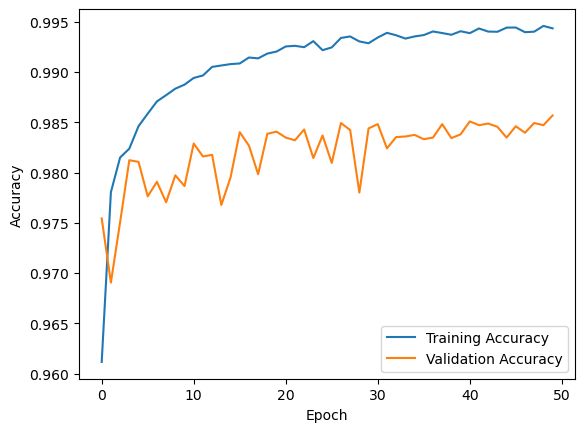

In [307]:
# Plot training and validation loss over epochs
plt.plot(history_squeezenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_squeezenet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

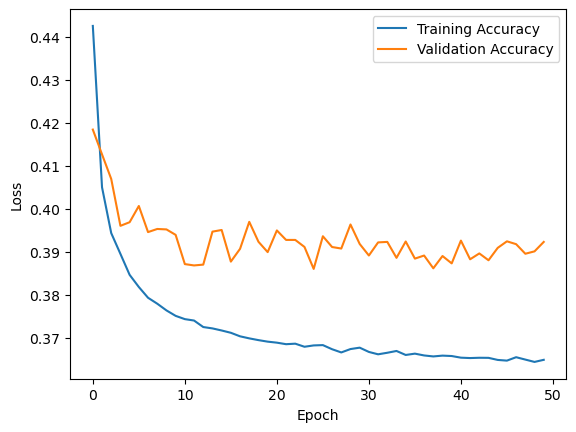

In [308]:
plt.plot(history_squeezenet.history['loss'], label='Training Accuracy')
plt.plot(history_squeezenet.history['val_loss'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [309]:
inference_start_squeezenet = time.time()
results = squeezeNet.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
inference_end_squeezenet = time.time()
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")

498/498 [==============================] - 4s 8ms/step - loss: 0.3818 - accuracy: 0.9857
Testing on CNR_EXT dataset: test loss: 0.38176557421684265, test acc: 0.9857030510902405


### Quantization

In [310]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    # Model has only one input so each data point has one element.
    #input_value = input_value.numpy()  # Convert TensorFlow tensor to NumPy array
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(squeezeNet)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/squeezenet_lite2.tflite', 'wb') as f:
    f.write(quantized_model)


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmp0rzikb2r/assets


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmp0rzikb2r/assets
/Users/aruzhan/anaconda3/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-11-17 15:22:45.416061: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-17 15:22:45.416200: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-17 15:22:45.416731: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmp0rzikb2r
2023-11-17 15:22:45.420691: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-17 15:22:45.420700: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn

In [312]:
interpreter = tf.lite.Interpreter(model_path='models/squeezenet_lite2.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
print("input_index:", input_index)

input_shape = interpreter.get_input_details()[0]['shape']
print("Expected input shape:", input_shape)

# Initialize variables for accuracy calculation
correct_predictions = 0
total_samples = 0

for batch_input_data, batch_true_labels in val_dataset:
    # Iterate through each sample in the batch
    for i in range(batch_input_data.shape[0]):        
        input_data = batch_input_data[i:i + 1]

        # Set input tensor
        interpreter.set_tensor(input_index, input_data.numpy())

        # Run inference
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_index)  
        true_label = batch_true_labels[i].numpy()
        print(output_data)
        print(true_label)
        # predicted_label = (output_data >= 0.5).astype(int)
        # print(predicted_label)        
        # print(true_label)
        # if predicted_label == true_label:            
        #     correct_predictions += 1
        predicted_label = np.argmax(output_data, axis=1)
        print(predicted_label)
        true_label = np.argmax(true_label)
        print(true_label)
        if predicted_label == true_label:    
            print("here")
            correct_predictions += 1
        total_samples += 1

    if total_samples > 300:
        break
# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f'Accuracy: {accuracy * 100:.2f}%')
print(total_samples)


input_index: 0
Expected input shape: [ 1 32 32  3]
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.99609375 0.00390625]]
[1. 0.]
[0]
0
here
[[0.99609375 0.00390625]]
[1. 0.]
[0]
0
here
[[0.01171875 0.98828125]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.

### Data augmentation

In [318]:
training_start_squeezenet_aug = time.time()
# Train the model
history_squeezenet_aug = squeezeNet.fit(
    train_dataset_augmented,
    epochs=epochs,
    validation_data=val_dataset
)
training_end_squeezenet_aug = time.time()

# Save the trained model
model.save('models/squeezenet_augmented.h5')

Epoch 1/50
1477/1477 [==============================] - 63s 42ms/step - loss: 0.4007 - accuracy: 0.9688 - val_loss: 0.3851 - val_accuracy: 0.9786
Epoch 2/50
1477/1477 [==============================] - 60s 40ms/step - loss: 0.3938 - accuracy: 0.9736 - val_loss: 0.3857 - val_accuracy: 0.9798
Epoch 3/50
1477/1477 [==============================] - 59s 39ms/step - loss: 0.3916 - accuracy: 0.9756 - val_loss: 0.3859 - val_accuracy: 0.9793
Epoch 4/50
1477/1477 [==============================] - 58s 39ms/step - loss: 0.3903 - accuracy: 0.9760 - val_loss: 0.3838 - val_accuracy: 0.9822
Epoch 5/50
1477/1477 [==============================] - 57s 38ms/step - loss: 0.3882 - accuracy: 0.9771 - val_loss: 0.3831 - val_accuracy: 0.9839
Epoch 6/50
1477/1477 [==============================] - 57s 38ms/step - loss: 0.3890 - accuracy: 0.9769 - val_loss: 0.3828 - val_accuracy: 0.9812
Epoch 7/50
1477/1477 [==============================] - 58s 39ms/step - loss: 0.3875 - accuracy: 0.9788 - val_loss: 0.3802 -

/Users/aruzhan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


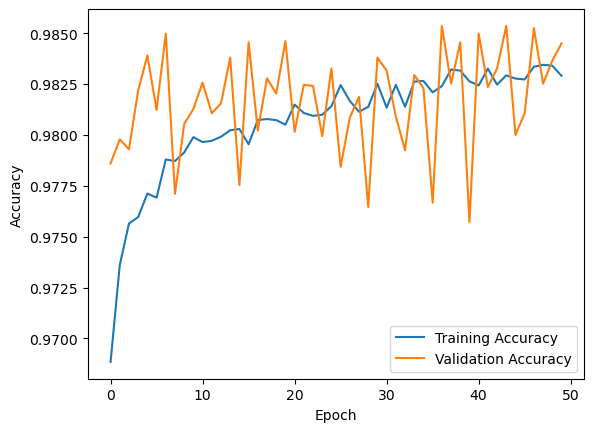

In [319]:
# Plot training and validation loss over epochs
plt.plot(history_squeezenet_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_squeezenet_aug.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

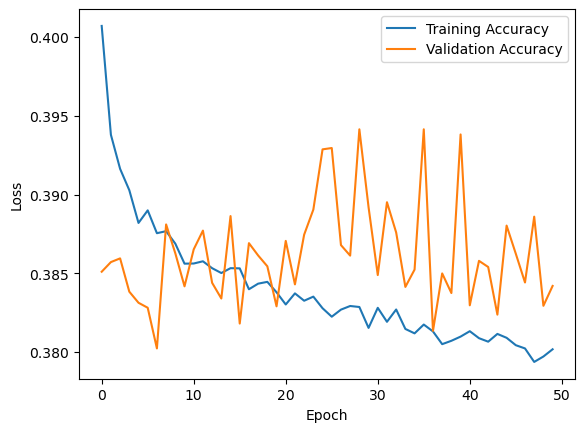

In [320]:
# Plot training and validation loss over epochs
plt.plot(history_squeezenet_aug.history['loss'], label='Training Accuracy')
plt.plot(history_squeezenet_aug.history['val_loss'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [321]:
inference_start_squeezenet_aug = time.time()
results = squeezeNet.evaluate(
    test_dataset,
    max_queue_size = 10,
    workers = os.cpu_count(),
)
inference_end_squeezenet_aug = time.time()
print(f"Testing on CNR_EXT dataset: test loss: {results[0]}, test acc: {results[1]}")

498/498 [==============================] - 4s 8ms/step - loss: 0.3765 - accuracy: 0.9866
Testing on CNR_EXT dataset: test loss: 0.37649935483932495, test acc: 0.9866142868995667


### Data augmentation + Quantization

In [322]:
def representative_data_gen():
  for input_value, labels in train_dataset.take(2):
    # Model has only one input so each data point has one element.
    #input_value = input_value.numpy()  # Convert TensorFlow tensor to NumPy array
    yield [input_value]

# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(squeezeNet)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
quantized_model = converter.convert()

with open('models/squeezenet_augmented_lite2.tflite', 'wb') as f:
    f.write(quantized_model)


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmpv87_nctd/assets


INFO:tensorflow:Assets written to: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmpv87_nctd/assets
/Users/aruzhan/anaconda3/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-11-17 16:20:02.292221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-17 16:20:02.292378: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-17 16:20:02.293999: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/tmpv87_nctd
2023-11-17 16:20:02.298184: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-17 16:20:02.298191: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn

In [323]:
interpreter = tf.lite.Interpreter(model_path='models/squeezenet_augmented_lite2.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
print("input_index:", input_index)

input_shape = interpreter.get_input_details()[0]['shape']
print("Expected input shape:", input_shape)

# Initialize variables for accuracy calculation
correct_predictions = 0
total_samples = 0

for batch_input_data, batch_true_labels in val_dataset:
    # Iterate through each sample in the batch
    for i in range(batch_input_data.shape[0]):        
        input_data = batch_input_data[i:i + 1]

        # Set input tensor
        interpreter.set_tensor(input_index, input_data.numpy())

        # Run inference
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_index)  
        true_label = batch_true_labels[i].numpy()
        print(output_data)
        print(true_label)
        # predicted_label = (output_data >= 0.5).astype(int)
        # print(predicted_label)        
        # print(true_label)
        # if predicted_label == true_label:            
        #     correct_predictions += 1
        predicted_label = np.argmax(output_data, axis=1)
        print(predicted_label)
        true_label = np.argmax(true_label)
        print(true_label)
        if predicted_label == true_label:    
            print("here")
            correct_predictions += 1
        total_samples += 1

    if total_samples > 300:
        break
# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f'Accuracy: {accuracy * 100:.2f}%')
print(total_samples)


input_index: 0
Expected input shape: [ 1 32 32  3]
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.00390625]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.00390625 0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.9921875 0.0078125]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.         0.99609375]]
[0. 1.]
[1]
1
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.99609375 0.        ]]
[1. 0.]
[0]
0
here
[[0.  

### Visual Representation 

In [324]:
training_time_malexnet = training_end_malexnet - training_start_malexnet
training_time_mdensenet = training_end_mdensenet - training_start_mdensenet
training_time_malexnet_aug = training_end_malexnet_aug - training_start_malexnet_aug
training_time_mdensenet_aug = training_end_mdensenet_aug - training_start_mdensenet_aug
training_time_squeezenet = training_end_squeezenet - training_start_squeezenet
training_time_squeezenet_aug = training_end_squeezenet_aug - training_start_squeezenet_aug
inference_time_malexnet = (inference_end_malexnet - inference_start_malexnet) 
inference_time_mdensenet = (inference_end_mdensenet - inference_start_mdensenet) 
inference_time_malexnet_aug = (inference_end_malexnet_aug - inference_start_malexnet_aug) 
inference_time_mdensenet_aug = (inference_end_mdensenet_aug - inference_start_mdensenet_aug)
inference_time_squeezenet = (inference_end_squeezenet - inference_start_squeezenet)
inference_time_squeezenet_aug = (inference_end_squeezenet_aug - inference_start_squeezenet_aug)
print('training time, malexnet standard: ', training_time_malexnet)
print('inference time, malexnet standard: ', inference_time_malexnet)
print('training time, malexnet augmented: ', training_time_malexnet_aug)
print('inference time, malexnet augmented: ', inference_time_malexnet_aug)
print('training time, mdensenet standard: ', training_time_mdensenet)
print('inference time, mdensenet standard: ', inference_time_mdensenet)
print('training time, mdensenet augmented: ', training_time_mdensenet_aug)
print('inference time, mdensenet augmented: ', inference_time_mdensenet_aug)
print('training time, squeezenet standard: ', training_time_squeezenet)
print('inference time, squeezenet standard: ', inference_time_squeezenet)
print('training time, squeezenet augmented: ', training_time_squeezenet_aug)
print('inference time, squeezenet augmented: ', inference_time_squeezenet_aug)

training time, malexnet standard:  1299.3517150878906
inference time, malexnet standard:  3.4701969623565674
training time, malexnet augmented:  3002.119462251663
inference time, malexnet augmented:  3.5393450260162354
training time, mdensenet standard:  452.1286458969116
inference time, mdensenet standard:  1.9176850318908691
training time, mdensenet augmented:  3318.2384748458862
inference time, mdensenet augmented:  2.121649742126465
training time, squeezenet standard:  1735.742676973343
inference time, squeezenet standard:  4.062793970108032
training time, squeezenet augmented:  2966.525975704193
inference time, squeezenet augmented:  4.378549098968506


In [41]:
training_time_malexnet = training_end_malexnet - training_start_malexnet
# training_time_mdensenet = training_end_mdensenet - training_start_mdensenet
training_time_malexnet_aug = training_end_malexnet_aug - training_start_malexnet_aug
# training_time_mdensenet_aug = training_end_mdensenet_aug - training_start_mdensenet_aug
# training_time_squeezenet = training_end_squeezenet - training_start_squeezenet
# training_time_squeezenet_aug = training_end_squeezenet_aug - training_start_squeezenet_aug
inference_time_malexnet = (inference_end_malexnet - inference_start_malexnet) 
# inference_time_mdensenet = (inference_end_mdensenet - inference_start_mdensenet) 
inference_time_malexnet_aug = (inference_end_malexnet_aug - inference_start_malexnet_aug) 
# inference_time_mdensenet_aug = (inference_end_mdensenet_aug - inference_start_mdensenet_aug)
# inference_time_squeezenet = (inference_end_squeezenet - inference_start_squeezenet)
# inference_time_squeezenet_aug = (inference_end_squeezenet_aug - inference_start_squeezenet_aug)

training_time_mdensenet = 452.1286458969116
inference_time_mdensenet = 1.9176850318908691
training_time_mdensenet_aug = 3318.2384748458862
inference_time_mdensenet_aug = 2.121649742126465
training_time_squeezenet = 1735.742676973343
inference_time_squeezenet = 4.062793970108032
training_time_squeezenet_aug = 2966.525975704193
inference_time_squeezenet_aug = 4.378549098968506

/var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/ipykernel_80594/1537107606.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(models, rotation=45, ha='right')
/var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/ipykernel_80594/1537107606.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(models, rotation=45, ha='right')


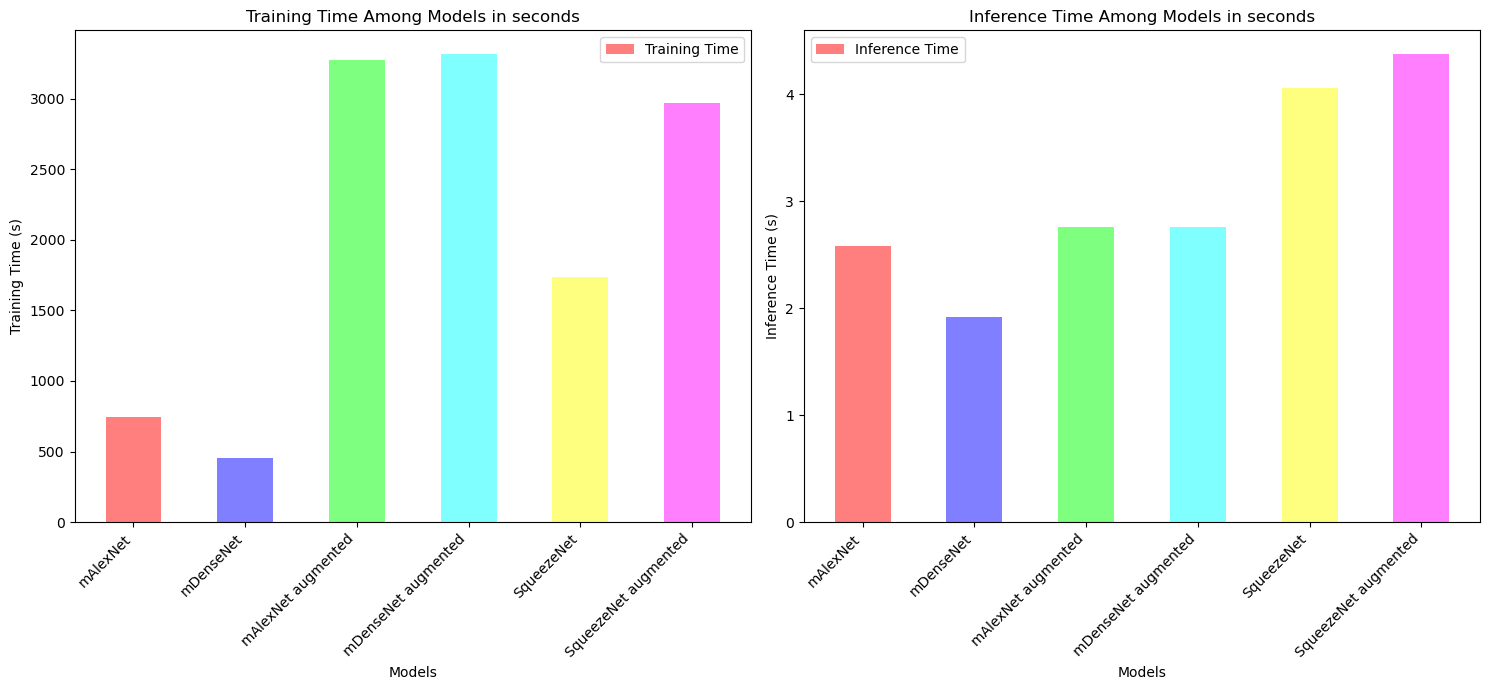

In [42]:
# Visualisation
models = ["mAlexNet", "mDenseNet", "mAlexNet augmented", "mDenseNet augmented", "SqueezeNet", "SqueezeNet augmented"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.bar(models, [training_time_malexnet, training_time_mdensenet, training_time_malexnet_aug, training_time_mdensenet_aug, training_time_squeezenet, training_time_squeezenet_aug], width=0.5, color=[(1, 0, 0, 0.5), (0, 0, 1, 0.5), (0, 1, 0, 0.5), (0, 1, 1, 0.5), (1, 1, 0, 0.5), (1, 0, 1, 0.5)], label='Training Time')
ax1.set_xlabel('Models')
ax1.set_ylabel('Training Time (s)')
ax1.set_title('Training Time Among Models in seconds')
ax1.legend()
ax1.set_xticklabels(models, rotation=45, ha='right')

ax2.bar(models, [inference_time_malexnet, inference_time_mdensenet, inference_time_malexnet_aug, inference_time_malexnet_aug, inference_time_squeezenet, inference_time_squeezenet_aug], width=0.5, color=[(1, 0, 0, 0.5), (0, 0, 1, 0.5), (0, 1, 0, 0.5), (0, 1, 1, 0.5), (1, 1, 0, 0.5), (1, 0, 1, 0.5)], label='Inference Time')
ax2.set_xlabel('Models')
ax2.set_ylabel('Inference Time (s)')
ax2.set_title('Inference Time Among Models in seconds')
ax2.legend()
ax2.set_xticklabels(models, rotation=45, ha='right') 

plt.tight_layout()
plt.show()